# Determining spatiotemporal blocking for ST-CV
Nachat Jatusripitak

In [1]:
# Import required packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import skgstat as skg
from sklearn.cluster import KMeans

plt.style.use('ggplot') # set plot style (R is best)

In [2]:
# Load dataset as CSV and print out the first few rows
df = pd.read_csv("../datasets/base.csv")
print(df.head(10))

   row  col        date     pm25_t  u_wind_10m_t  v_wind_10m_t  dew_temp_2m_t  \
0    0    0  2018-07-05   8.317946      1.432791      0.080936      291.41534   
1    0    0  2018-07-06   8.919353      0.748148      0.110430      291.74884   
2    0    0  2018-07-07   8.957355      0.922457      0.196369      292.11148   
3    0    0  2018-07-08   9.513633      1.040234      0.047216      291.94238   
4    0    0  2018-07-09   9.022613      1.154719      0.083273      290.86307   
5    0    0  2018-07-10  10.063774      0.976790      0.045969      291.47990   
6    0    0  2018-07-11  10.022911      0.404936      0.088748      292.56885   
7    0    0  2018-07-12  11.173699      0.189519      0.284812      292.07114   
8    0    0  2018-07-13  11.481783      0.299176      0.200764      291.94904   
9    0    0  2018-07-14  10.089383      0.395432      0.282515      291.47247   

   temp_2m_t  surf_pressure_t  precip_sum_t  frp_t  elevation_t  \
0  295.22916        85304.766      0.0034

### Question 1: is $\Delta PM_{2.5}$ a stationary process?
- Augmented Dickey–Fuller test conducted on mean PM2.5 change (daily) indicates that <br>
$\Delta PM_{2.5}$ is a stationary process.

In [3]:
daily_mean_pm25 = df.groupby("date")["pm25_t"].mean()
result = adfuller(daily_mean_pm25.values)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
    print("\u001b[32mStationary\u001b[0m")
else:
    print("\x1b[31mNon-stationary\x1b[0m")

ADF Statistic: -3.523574
p-value: 0.007402
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


### Question 2: what is its global temporal autocorrelation?
- ACF plot shows geometric decay with significant correlation at lags 1-3.
- PACF plot shows geometric decay with signficant correlation at lags 1-2.
- Lack of significance tailoff may be due to noise.
- Results suggest either an AR(1)/AR(2) process or an ARMA(1, 1) process.

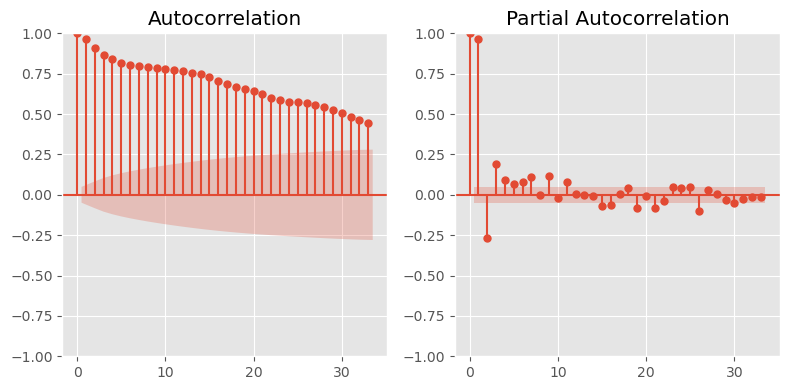

In [27]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
plot_acf(daily_mean_pm25, ax=ax[0])
plot_pacf(daily_mean_pm25, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

### Question 3: what is its local temporal autocorrelation?
- Used K-means clustering with K=6 to cluster spatial locations by their summary statistics.
- ACF/PACF plots were generated for each cluster medoid.
- Most plots indicate some form of AR or ARMA process.

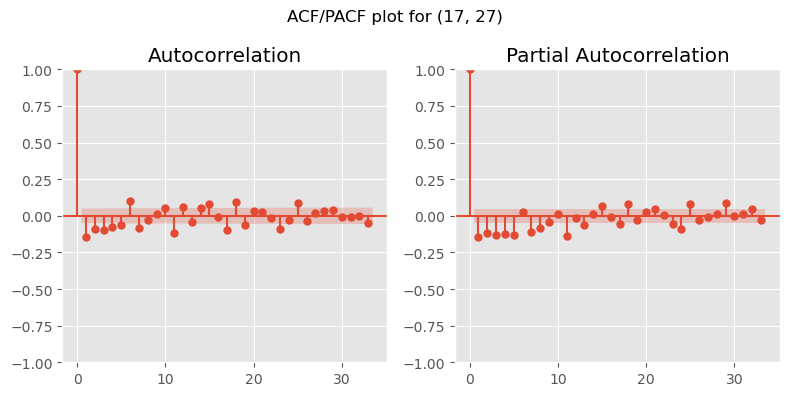

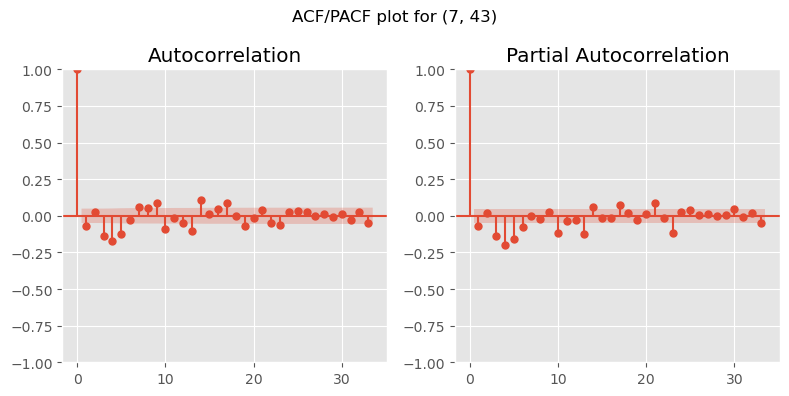

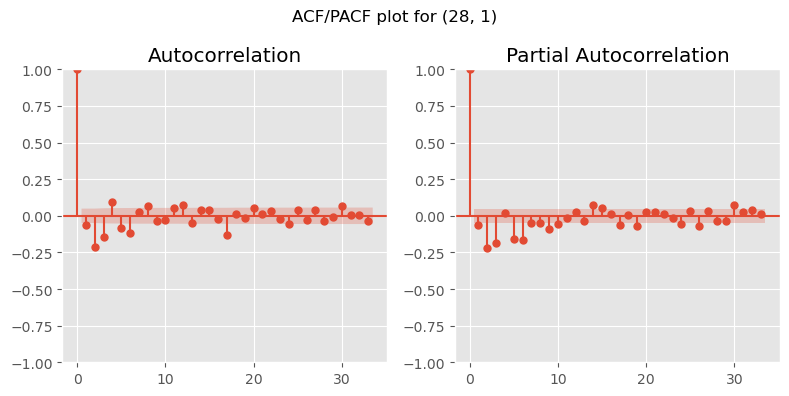

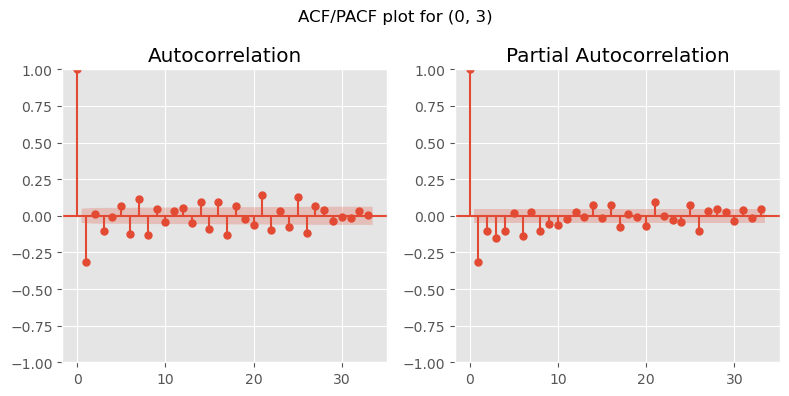

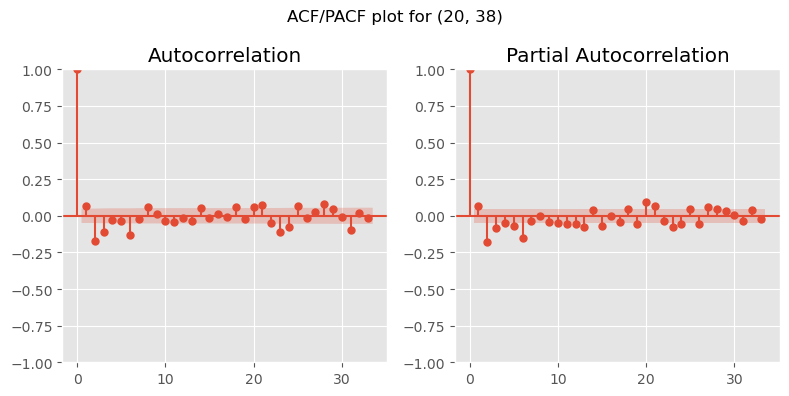

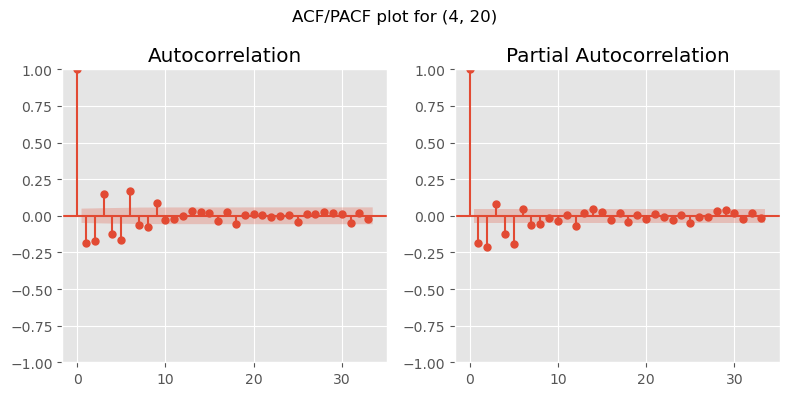

In [5]:
# Get location-based summary statistics
pixel_summaries = df.groupby(["row", "col"])["pm25_change"].describe().drop("count", axis=1)
K = 6
kmeans = KMeans(n_clusters=K, random_state=191)
pixel_summaries['cluster'] = kmeans.fit_predict(pixel_summaries.values)


medoids = []
for i in range(K):
    mask = pixel_summaries['cluster'] == i
    center = kmeans.cluster_centers_[i]
    points  = pixel_summaries.loc[mask].drop("cluster", axis=1).values
    idxs    = pixel_summaries.index[mask]
    dists   = np.linalg.norm(points - center, axis=1)
    medoids.append(idxs[np.argmin(dists)])

for i in range(len(medoids)):
    row, col = medoids[i]

    mask = (df["row"] == row) & (df["col"] == col)

    sub = df.loc[mask, ['date', 'pm25_change']].copy()

    sub['date'] = pd.to_datetime(sub['date'])

    ts = sub.set_index('date').sort_index()

    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    f.suptitle(f"ACF/PACF plot for ({row}, {col})")
    plot_acf(ts, ax=ax[0])
    plot_pacf(ts, ax=ax[1], method='ols')
    
    plt.tight_layout()
    plt.show()

### Question 3: what is its spatial autocorrelation?
- Sampled N days and computed variograms for the data on each day

/opt/anaconda3/envs/CS191W/lib/python3.11/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


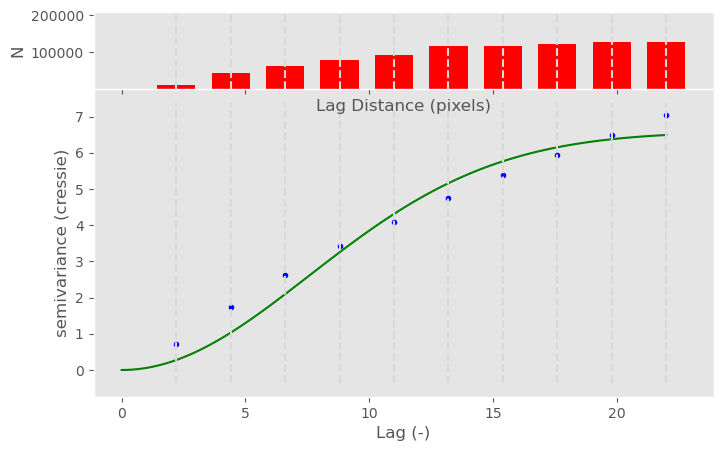

2022-10-23 21.337955438275397
21.337955438275397


In [5]:
np.random.seed(0) # for reproducibility

# Create a full date range
all_dates = pd.date_range(start='2018-07-04', end='2022-12-31', freq='D')

# Randomly sample N days
sampled_dates = np.random.choice(all_dates, size=1, replace=False, )

ranges = []

for date in sampled_dates:
    date_str = str(date)[:10]
    df_filtered = df[df["date"] == date_str]
    if len(df_filtered) == 0:
        continue

    coords = df_filtered[['col', 'row']].to_numpy()  # order = (x, y)
    values = df_filtered['delta_pm25_t'].to_numpy()

    V = skg.Variogram(
        coords,
        values,
        model='gaussian',
        estimator='cressie',
        maxlag=22         # max distance in grid units
    )

    fig = V.plot()
    plt.xlabel('Lag Distance (pixels)')
    plt.show()

    range_ = V.parameters[0]
    ranges.append(range_)
    print(date_str, range_)

print(np.percentile(ranges, 50))